In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.init as init
import os
import torch.nn as nn
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

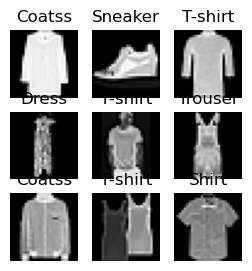

In [3]:
labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coatss',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize=(3, 3))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Data Loaders


In [4]:
batch_size = 128

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# NetA1ByHand

CNN with 1 Conv layer and 1 Fully Connected layer.

- **Conv Layer**: 1 input channel, 5 output channels, 3x3 kernels
- **Activation**: ReLU
- **Flatten**: Flattens output from Conv layer
- **FC Layer**: Outputs `num_classes`

## Custom Kernel Initialization

Conv layer uses 5 manually set filters:

1. Main diagonal
2. Secondary diagonal
3. Top edge
4. Left edge
5. All ones

## Optional

Set `freeze_first_layer=True` to freeze Conv layer during training.


In [5]:
class NetA1ByHand(nn.Module):
    def __init__(self, num_classes=len(labels_map), freeze_first_layer=False):
        super(NetA1ByHand, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calcolo automatico dimensione input per fc1
        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            x = self.relu(self.conv1(dummy_input))
            x = self.flatten(x)
            fc_input_dim = x.shape[1]

        self.fc1 = nn.Linear(fc_input_dim, num_classes)

        self._init_by_hand()

        if freeze_first_layer:
            for param in self.conv1.parameters():
                param.requires_grad = False

    def _init_by_hand(self):
        with torch.no_grad():
            patterns = torch.zeros_like(self.conv1.weight)

            # Kernel 0: diagonale principale
            patterns[0, 0] = torch.tensor([[1., 0., 0.],
                                           [0., 1., 0.],
                                           [0., 0., 1.]])

            # Kernel 1: diagonale secondaria
            patterns[1, 0] = torch.tensor([[0., 0., 1.],
                                           [0., 1., 0.],
                                           [1., 0., 0.]])

            # Kernel 2: bordo superiore
            patterns[2, 0] = torch.tensor([[1., 1., 1.],
                                           [0., 0., 0.],
                                           [0., 0., 0.]])

            # Kernel 3: bordo sinistro
            patterns[3, 0] = torch.tensor([[1., 0., 0.],
                                           [1., 0., 0.],
                                           [1., 0., 0.]])

            # Kernel 4: tutto 1
            patterns[4, 0] = torch.ones(3, 3)

            self.conv1.weight.copy_(patterns)
            self.conv1.bias.zero_()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# NetA1Default

CNN with default Kaiming weight initialization.

- **Conv Layer**: 1 input channel, 5 output channels, 3x3 kernel
- **Activation**: ReLU
- **Flatten**: Prepares data for fully connected layer
- **FC Layer**: Maps to `num_classes`

## Initialization

- Conv layer weights initialized with **Kaiming uniform**


In [6]:
class NetA1Default(nn.Module):
    def __init__(self, num_classes=len(labels_map)):
        super(NetA1Default, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calcolo automatico dimensione input per fc1
        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            dummy_out = self.relu(self.conv1(dummy_input))
            fc_input_dim = dummy_out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(fc_input_dim, num_classes)


        self._init_kaiming()


    def _init_kaiming(self):
        init.kaiming_uniform_(self.conv1.weight, nonlinearity="relu")
        if self.conv1.bias is not None:
            nn.init.zeros_(self.conv1.bias)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return x



# NetA2ByHand

CNN with 2 Conv layers and 1 Fully Connected layer.

- **Conv1**:
  - 1 input channel
  - 5 output channels
  - 3x3 kernels
  - Custom handcrafted weights

- **Conv2**:
  - 5 input channels
  - 7 output channels
  - 3x3 kernels
  - Initialized with Kaiming uniform

- **Activation**: ReLU after each conv
- **Flatten**: Prepares data for FC layer
- **FC Layer**: Outputs `num_classes`

## Initialization

- Conv1: 5 manually defined filters (diagonals, edges, all-ones)
- Conv2 + FC: Kaiming uniform

## Optional

Set `freeze_first_layer=True` to freeze Conv1 during training.


In [7]:
class NetA2ByHand(nn.Module):
    def __init__(self, num_classes=len(labels_map), freeze_first_layer=False):
        super(NetA2ByHand, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3)

        self.conv2 = nn.Conv2d(in_channels=5, out_channels=7, kernel_size=3)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            x = self.relu(self.conv1(dummy_input))
            x = self.relu(self.conv2(x))
            x = self.flatten(x)
            fc_input_dim = x.shape[1]

        self.fc1 = nn.Linear(fc_input_dim, num_classes)

        self._init_by_hand()
        self._init_kaiming()

        # Freeza primo layer
        if freeze_first_layer:
            for param in self.conv1.parameters():
                param.requires_grad = False

    def _init_by_hand(self):
        with torch.no_grad():
            patterns = torch.zeros_like(self.conv1.weight)

            # Kernel 0: diagonale principale
            patterns[0, 0] = torch.tensor([[1., 0., 0.],
                                           [0., 1., 0.],
                                           [0., 0., 1.]])

            # Kernel 1: diagonale secondaria
            patterns[1, 0] = torch.tensor([[0., 0., 1.],
                                           [0., 1., 0.],
                                           [1., 0., 0.]])

            # Kernel 2: bordo superiore
            patterns[2, 0] = torch.tensor([[1., 1., 1.],
                                           [0., 0., 0.],
                                           [0., 0., 0.]])

            # Kernel 3: bordo sinistro
            patterns[3, 0] = torch.tensor([[1., 0., 0.],
                                           [1., 0., 0.],
                                           [1., 0., 0.]])

            # Kernel 4: tutto 1
            patterns[4, 0] = torch.ones(3, 3)

            self.conv1.weight.copy_(patterns)
            self.conv1.bias.zero_()

    def _init_kaiming(self):
        init.kaiming_uniform_(self.conv2.weight, nonlinearity="relu")
        if self.conv2.bias is not None:
            nn.init.zeros_(self.conv2.bias)

        init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# NetA2Default

CNN with 2 Conv layers and 1 Fully Connected layer.
All weights are initialized using Kaiming uniform.

- **Conv1**:
  - Input: 1 channel
  - Output: 5 channels
  - Kernel: 3x3

- **Conv2**:
  - Input: 5 channels
  - Output: 7 channels
  - Kernel: 3x3

- **Activation**: ReLU after each conv
- **Flatten**: Converts to 1D
- **FC Layer**: Outputs `num_classes`

## Initialization

- Weights (conv1, conv2, fc1): **Kaiming uniform**

In [8]:
class NetA2Default(nn.Module):
    def __init__(self, num_classes=len(labels_map)):
        super(NetA2Default, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3)

        self.conv2 = nn.Conv2d(in_channels=5, out_channels=7, kernel_size=3)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            x = self.relu(self.conv1(dummy_input))
            x = self.relu(self.conv2(x))
            x = self.flatten(x)
            fc_input_dim = x.shape[1]

        self.fc1 = nn.Linear(fc_input_dim, num_classes)

        self._init_kaiming()

    def _init_kaiming(self):
        init.kaiming_uniform_(self.conv1.weight, nonlinearity="relu")
        if self.conv1.bias is not None:
            nn.init.zeros_(self.conv1.bias)
        init.kaiming_uniform_(self.conv2.weight, nonlinearity="relu")
        if self.conv2.bias is not None:
            nn.init.zeros_(self.conv2.bias)

        init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# Train and Test loop

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, model_name):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        if batch == 0:
            print(f"[Batch {batch}] Shape X: {X.shape}, Shape y: {y.shape}")

        # Compute prediction and loss
        pred = model(X)

        if batch == 0:
            print(f"[Batch {batch}] Shape pred: {pred.shape}")

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100 * correct, test_loss


# Train Model

Train a neural network model using Adam optimizer and CrossEntropyLoss.

## Parameters

- `net`: the model to train
- `model_name`: model name

## Training Settings

- **Learning rate**: `1e-4`
- **Epochs**: `20`
- **Loss function**: CrossEntropyLoss
- **Optimizer**: Adam

In [10]:
learning_rate = 1e-4
epochs = 20


def train_model(net, model_name="Model"):
    print(f"\n Processing model: {model_name}")

    print(f" Training model: {model_name}")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    accuracies = []
    losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loop(train_dataloader, net, loss_fn, optimizer, model_name)
        accuracy, loss = test_loop(test_dataloader, net, loss_fn)
        print(f"→ Test Accuracy: {accuracy:.2f}% | Loss: {loss:.4f}")
        accuracies.append(accuracy)
        losses.append(loss)

    print(f" Training completed: {model_name}")

    result = {
        "model": model_name,
        "accuracies": accuracies,
        "losses": losses
    }

    return result

# Weight Management
Save, load, and compare model weights.

## Functions

- **save_layer_weights**: saves layer weights to a `.pt` file
- **load_layer_weights**: loads weights from file into a layer
- **compare_weights**: compares two layers and prints the difference
- **save_weights_if_missing**: saves weights only if file does not exist

## Folder

Creates a `weights/` folder automatically if it doesn't exist.

## Models Created

- `A1-HF`, `A1-HT`, `A1-DT`
- `A2-HF`, `A2-HT`, `A2-DT`

All models load their saved weights.

## Weight Comparison

Compares weights of `conv1`, `conv2`, and `fc1` between models.


In [11]:
os.makedirs("weights", exist_ok=True)


def save_layer_weights(layer, filename):
    torch.save(layer.state_dict(), filename)
    print(f"Saved weights to: '{filename}'")


def load_layer_weights(layer, filename):
    state_dict = torch.load(filename)
    layer.load_state_dict(state_dict)
    print(f"Loaded weights from: '{filename}'")


def compare_weights(layer1, layer2, name1, name2, label):
    w1 = layer1.weight.data
    w2 = layer2.weight.data
    diff_norm = torch.norm(w1 - w2).item()
    print(f"‖{name1}.{label} - {name2}.{label}‖ = {diff_norm:.6f}")
    return diff_norm


def save_weights_if_missing(model_class, label_prefix, layers):
    model = model_class()
    for layer_name, filename in layers:
        path = f"weights/{label_prefix}_{filename}.pt"
        if not os.path.exists(path):
            save_layer_weights(getattr(model, layer_name), path)


save_weights_if_missing(NetA1ByHand, "net1", [("conv1", "conv1"), ("fc1", "fc1")])
save_weights_if_missing(NetA2ByHand, "net2", [("conv2", "conv2"), ("fc1", "fc1")])
save_weights_if_missing(NetA1Default, "default", [("conv1", "conv1")])

print("\n️  Creating and loading models...\n")

# Set A1
model_a1_hf = NetA1ByHand(freeze_first_layer=True)
load_layer_weights(model_a1_hf.conv1, "weights/net1_conv1.pt")
load_layer_weights(model_a1_hf.fc1, "weights/net1_fc1.pt")

model_a1_ht = NetA1ByHand(freeze_first_layer=False)
load_layer_weights(model_a1_ht.conv1, "weights/net1_conv1.pt")
load_layer_weights(model_a1_ht.fc1, "weights/net1_fc1.pt")

model_a1_dt = NetA1Default()
load_layer_weights(model_a1_dt.conv1, "weights/default_conv1.pt")

# Set A2
model_a2_hf = NetA2ByHand(freeze_first_layer=True)
load_layer_weights(model_a2_hf.conv1, "weights/net1_conv1.pt")
load_layer_weights(model_a2_hf.conv2, "weights/net2_conv2.pt")
load_layer_weights(model_a2_hf.fc1, "weights/net2_fc1.pt")

model_a2_ht = NetA2ByHand(freeze_first_layer=False)
load_layer_weights(model_a2_ht.conv1, "weights/net1_conv1.pt")
load_layer_weights(model_a2_ht.conv2, "weights/net2_conv2.pt")
load_layer_weights(model_a2_ht.fc1, "weights/net2_fc1.pt")

model_a2_dt = NetA2Default()
load_layer_weights(model_a2_dt.conv1, "weights/default_conv1.pt")

print("\n Confronto pesi conv1 tra modelli:\n")

compare_weights(model_a1_hf.conv1, model_a1_ht.conv1, "A1-HF", "A1-HT", "conv1")
compare_weights(model_a1_hf.fc1, model_a1_ht.fc1, "A1-HF", "A1-HT", "fc1")

compare_weights(model_a1_hf.conv1, model_a2_hf.conv1, "A1-HF", "A2-HF", "conv1")
compare_weights(model_a1_hf.conv1, model_a2_ht.conv1, "A1-HF", "A2-HT", "conv1")
compare_weights(model_a1_ht.conv1, model_a2_hf.conv1, "A1-HT", "A2-HF", "conv1")
compare_weights(model_a1_ht.conv1, model_a2_ht.conv1, "A1-HT", "A2-HT", "conv1")

compare_weights(model_a2_hf.conv1, model_a2_ht.conv1, "A2-HF", "A2-HT", "conv1")
compare_weights(model_a2_hf.conv2, model_a2_ht.conv2, "A2-HF", "A2-HT", "conv2")
compare_weights(model_a2_hf.fc1, model_a2_ht.fc1, "A2-HF", "A2-HT", "fc1")

compare_weights(model_a1_dt.conv1, model_a2_dt.conv1, "A1-DT", "A2-DT", "conv1")


️  Creating and loading models...

Loaded weights from: 'weights/net1_conv1.pt'
Loaded weights from: 'weights/net1_fc1.pt'
Loaded weights from: 'weights/net1_conv1.pt'
Loaded weights from: 'weights/net1_fc1.pt'
Loaded weights from: 'weights/default_conv1.pt'
Loaded weights from: 'weights/net1_conv1.pt'
Loaded weights from: 'weights/net2_conv2.pt'
Loaded weights from: 'weights/net2_fc1.pt'
Loaded weights from: 'weights/net1_conv1.pt'
Loaded weights from: 'weights/net2_conv2.pt'
Loaded weights from: 'weights/net2_fc1.pt'
Loaded weights from: 'weights/default_conv1.pt'

 Confronto pesi conv1 tra modelli:

‖A1-HF.conv1 - A1-HT.conv1‖ = 0.000000
‖A1-HF.fc1 - A1-HT.fc1‖ = 0.000000
‖A1-HF.conv1 - A2-HF.conv1‖ = 0.000000
‖A1-HF.conv1 - A2-HT.conv1‖ = 0.000000
‖A1-HT.conv1 - A2-HF.conv1‖ = 0.000000
‖A1-HT.conv1 - A2-HT.conv1‖ = 0.000000
‖A2-HF.conv1 - A2-HT.conv1‖ = 0.000000
‖A2-HF.conv2 - A2-HT.conv2‖ = 0.000000
‖A2-HF.fc1 - A2-HT.fc1‖ = 0.000000
‖A1-DT.conv1 - A2-DT.conv1‖ = 0.000000


0.0

# Load Or Train

Loads a saved model and training results if they exist,
otherwise trains the model from scratch.

## Parameters

- `model`: the PyTorch model to train or load
- `model_name`: string name used for saving/loading files

## Behavior

- Checks if model weights (`models/{model_name}.pt`) and results (`results/{model_name}_results.pt`) exist
- If both exist, loads and returns the results
- If not, trains the model, saves weights and results, then returns results

## Folder structure

- Creates `models/` and `results/` folders if they don't exist


In [12]:
def load_or_train(model, model_name):
    model_file = f"models/{model_name}.pt"
    result_file = f"results/{model_name}_results.pt"

    if os.path.exists(model_file) and os.path.exists(result_file):
        print(f" Caricamento di modello e risultati per: {model_name}")

        with open(result_file, "rb") as f:
            return torch.load(f)
    else:
        results = train_model(model, model_name=model_name)

        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), model_file)

        os.makedirs("results", exist_ok=True)
        with open(result_file, "wb") as f:
            torch.save(results, f)

        return results

In [13]:
results = {}

# Set A1
results["A1-HF"] = load_or_train(model_a1_hf, "A1 - HF (Frozen)")
results["A1-HT"] = load_or_train(model_a1_ht, "A1 - HT (Trainable)")
results["A1-DT"] = load_or_train(model_a1_dt, "A1 - DT (Trainable)")

# Set A2
results["A2-HF"] = load_or_train(model_a2_hf, "A2 - HF (Frozen)")
results["A2-HT"] = load_or_train(model_a2_ht, "A2 - HT (Trainable)")
results["A2-DT"] = load_or_train(model_a2_dt, "A2 - DT (Trainable)")

 Caricamento di modello e risultati per: A1 - HF (Frozen)
 Caricamento di modello e risultati per: A1 - HT (Trainable)
 Caricamento di modello e risultati per: A1 - DT (Trainable)
 Caricamento di modello e risultati per: A2 - HF (Frozen)
 Caricamento di modello e risultati per: A2 - HT (Trainable)
 Caricamento di modello e risultati per: A2 - DT (Trainable)


# Experiments and Plots

In [14]:
def plot_metrics(results):
    num_epochs = len(next(iter(results.values()))["accuracies"])
    epoch_range = list(range(1, num_epochs + 1))

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for name, metrics in results.items():
        plt.plot(epoch_range, metrics["accuracies"], marker='o', label=name)
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.xticks(epoch_range)
    plt.grid(True)
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for name, metrics in results.items():
        plt.plot(epoch_range, metrics["losses"], marker='x', label=name)
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(epoch_range)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


def summarize_results(results):
    print("\n Confronto finale (ultima epoca):")
    print(f"{'Modello':<10} | {'Accuracy %':>10} | {'Loss':>10}")
    print("-" * 35)
    for name, metrics in results.items():
        acc = metrics["accuracies"][-1]
        loss = metrics["losses"][-1]
        print(f"{name:<10} | {acc:>10.2f} | {loss:>10.4f}")
    print("-" * 35)



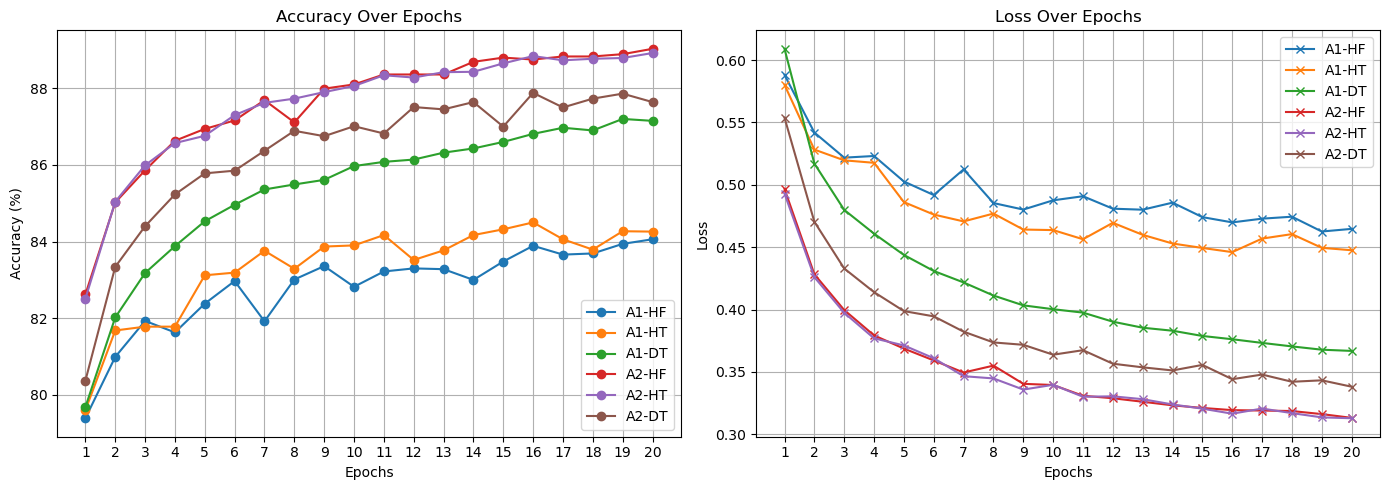


 Confronto finale (ultima epoca):
Modello    | Accuracy % |       Loss
-----------------------------------
A1-HF      |      84.06 |     0.4647
A1-HT      |      84.26 |     0.4475
A1-DT      |      87.15 |     0.3668
A2-HF      |      89.03 |     0.3132
A2-HT      |      88.92 |     0.3129
A2-DT      |      87.64 |     0.3381
-----------------------------------


In [15]:
plot_metrics(results)
summarize_results(results)

In [16]:
def plot_experiment(results, keys, title, ylabel="Accuracy", metric="accuracies"):
    plt.figure(figsize=(10, 6))
    for key in keys:
        plt.plot(results[key][metric], label=key)
    plt.title(f"{title} ({ylabel})")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

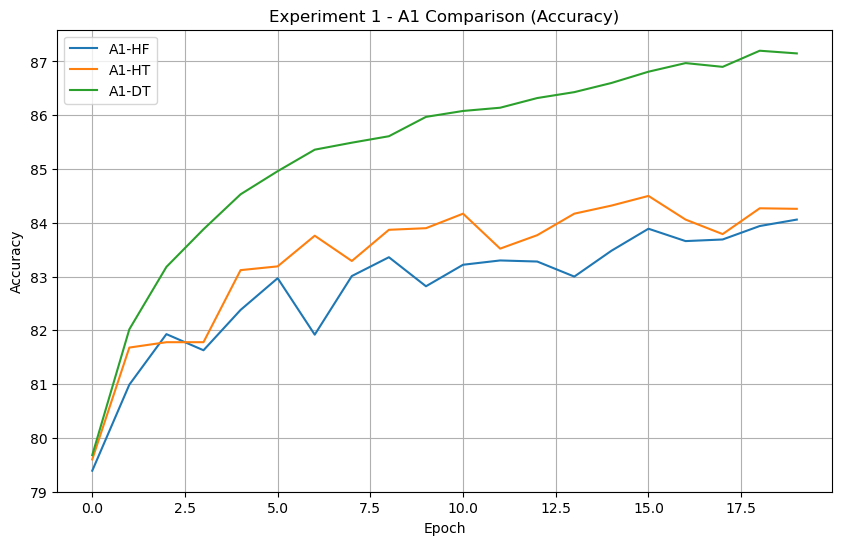

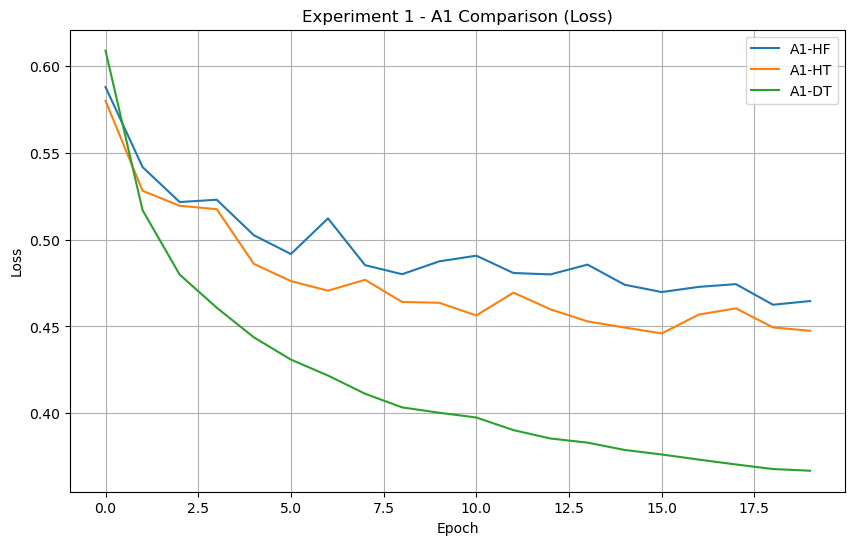

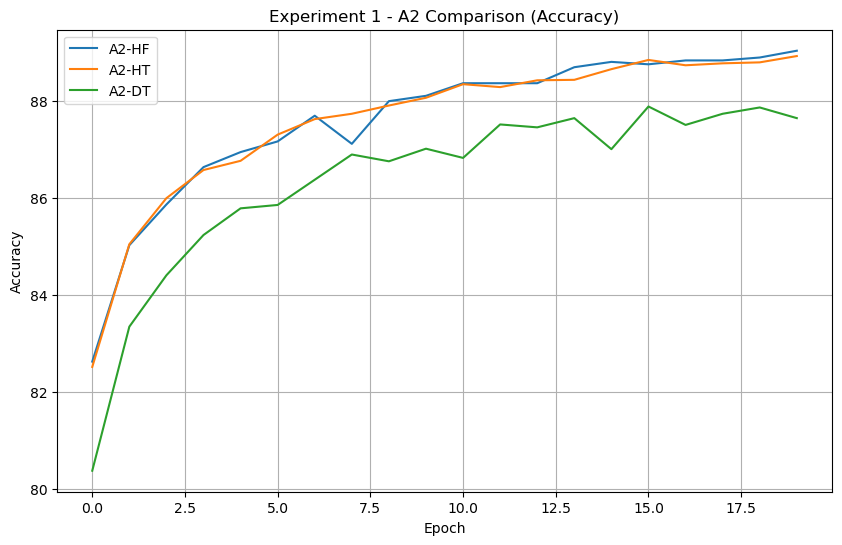

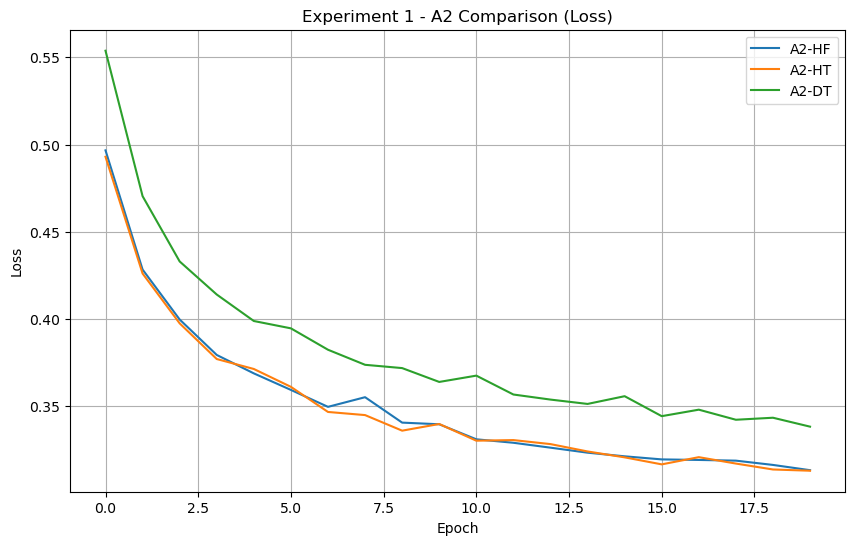

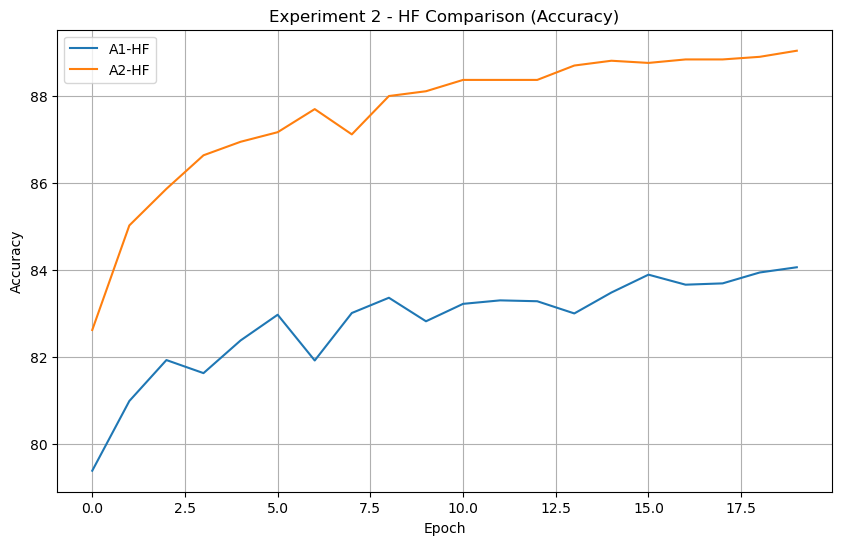

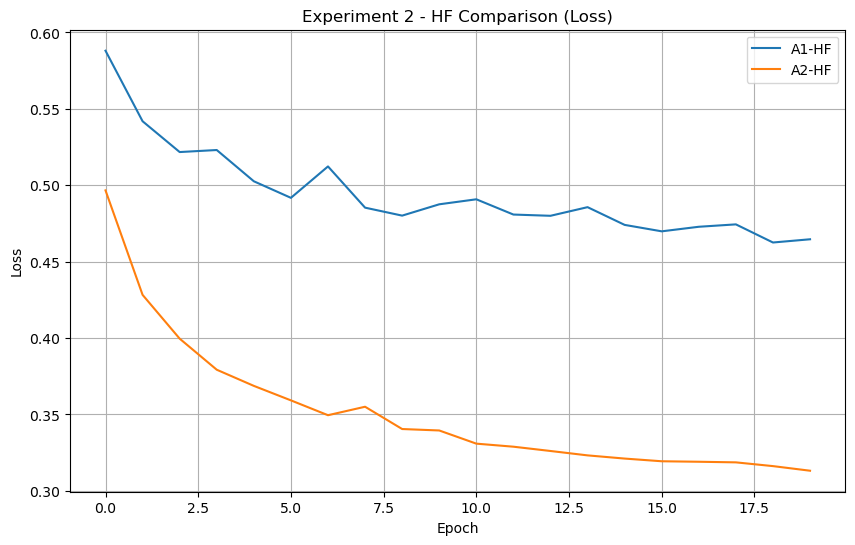

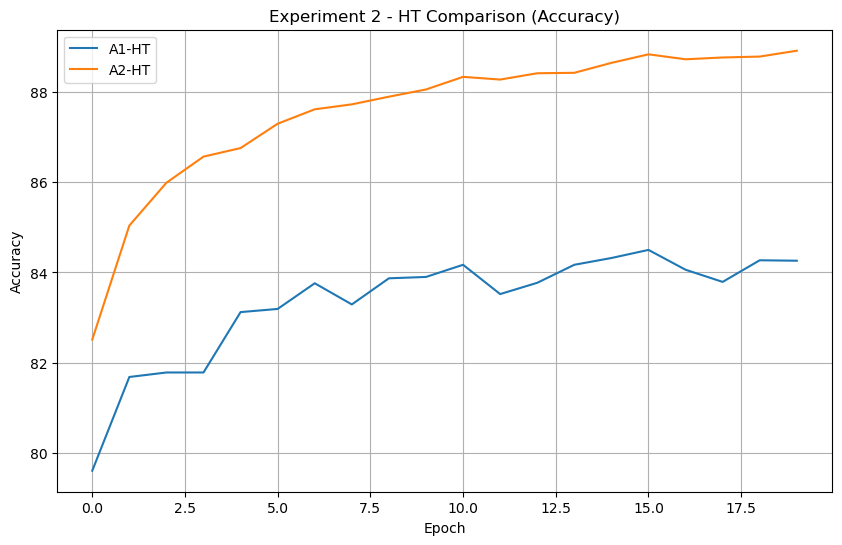

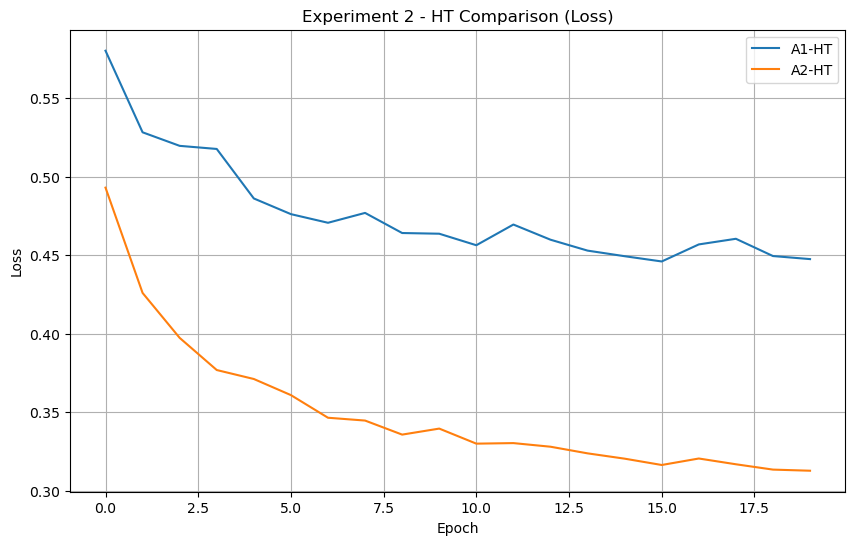

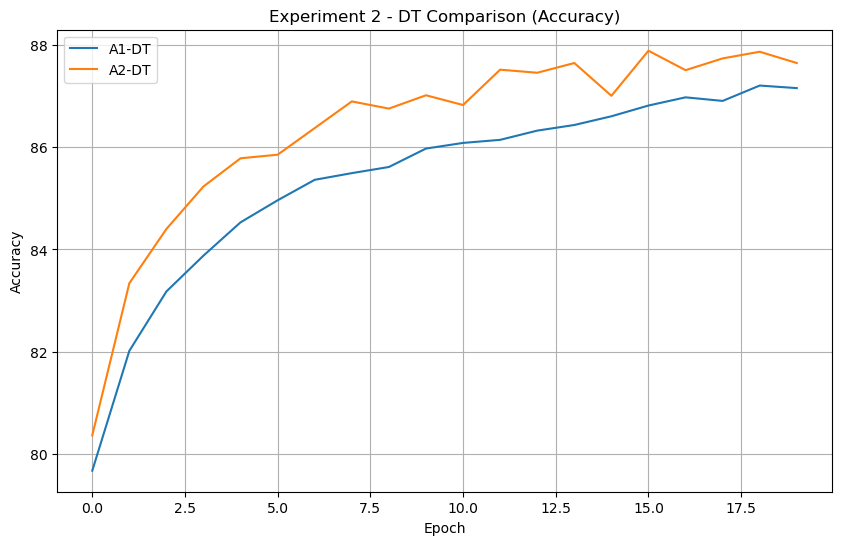

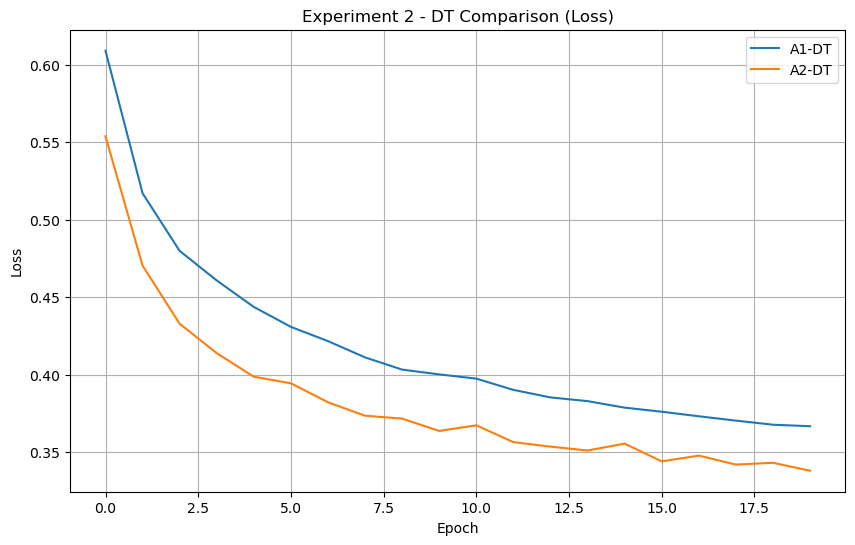

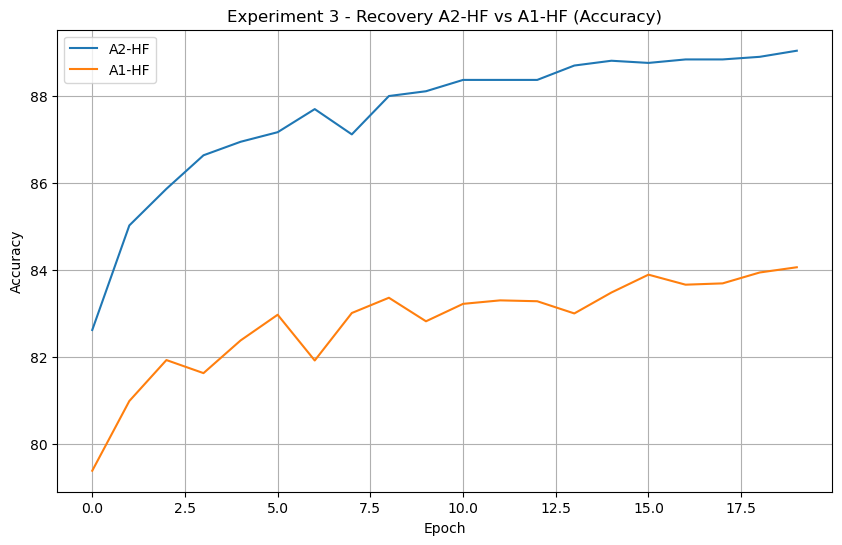

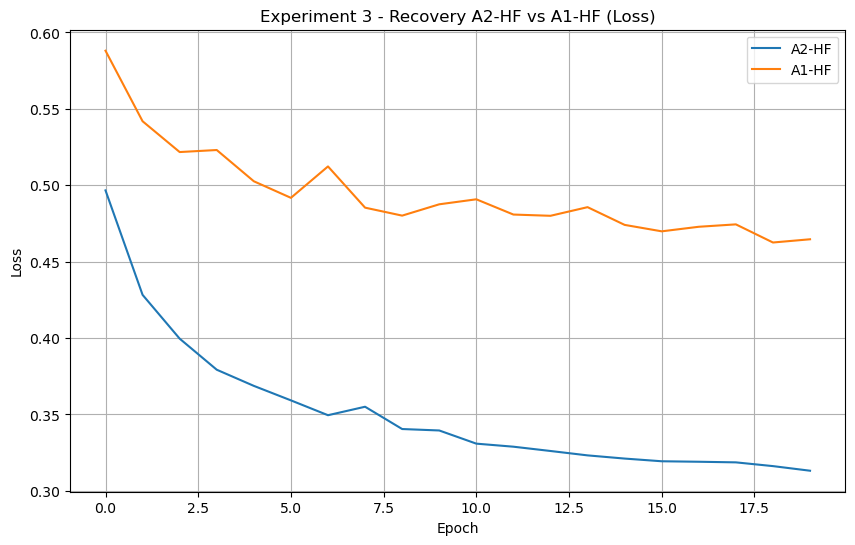

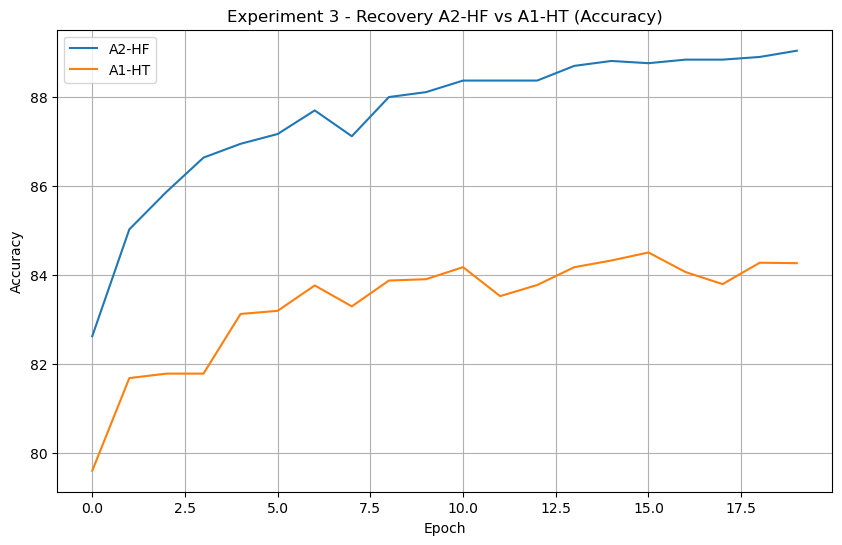

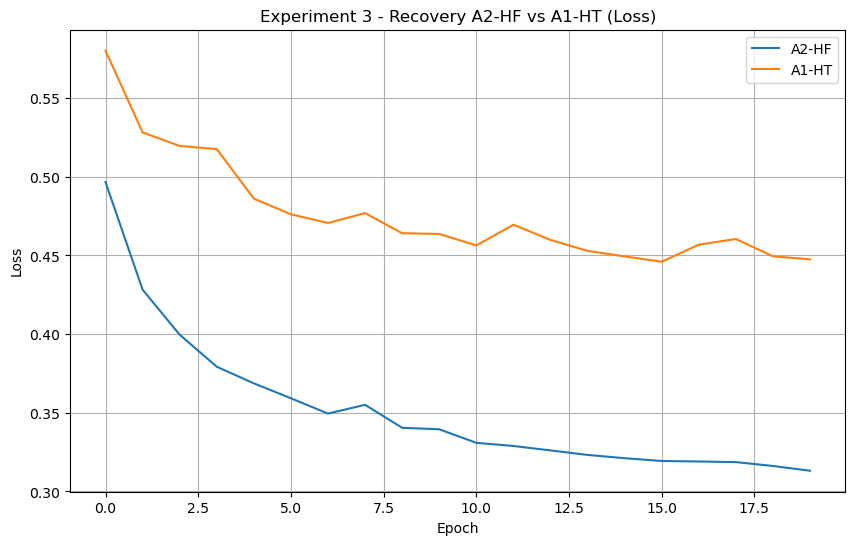

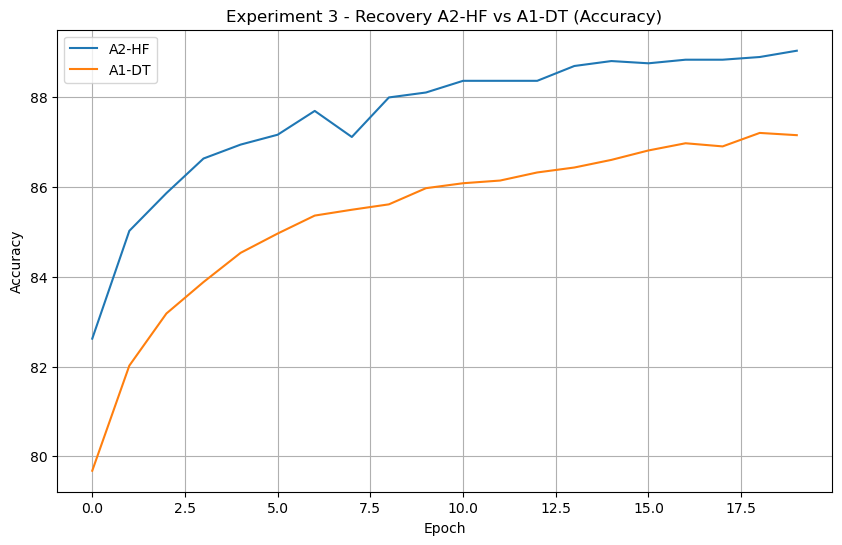

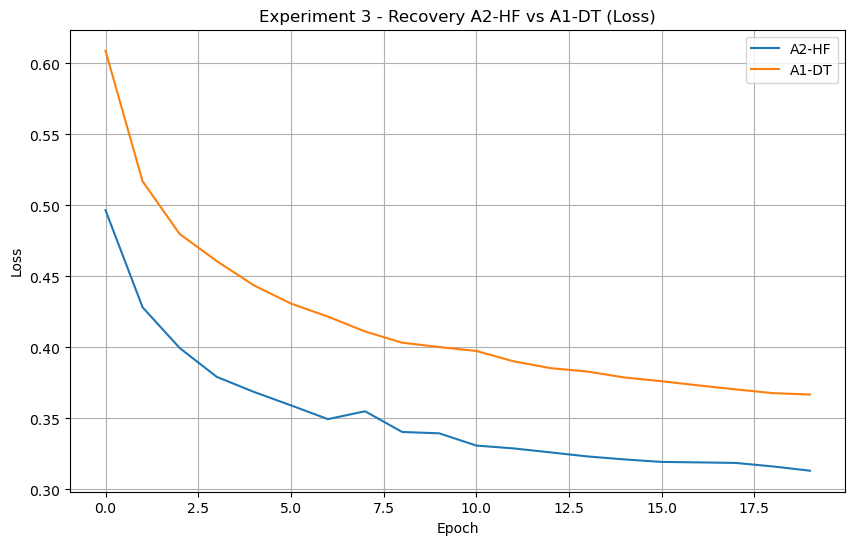

In [17]:
# ===  Experiment 1: Inset comparison ===
plot_experiment(results, ["A1-HF", "A1-HT", "A1-DT"], "Experiment 1 - A1 Comparison", "Accuracy")
plot_experiment(results, ["A1-HF", "A1-HT", "A1-DT"], "Experiment 1 - A1 Comparison", "Loss", metric="losses")

plot_experiment(results, ["A2-HF", "A2-HT", "A2-DT"], "Experiment 1 - A2 Comparison", "Accuracy")
plot_experiment(results, ["A2-HF", "A2-HT", "A2-DT"], "Experiment 1 - A2 Comparison", "Loss", metric="losses")

# ===  Experiment 2: Architecture comparison ===
plot_experiment(results, ["A1-HF", "A2-HF"], "Experiment 2 - HF Comparison", "Accuracy")
plot_experiment(results, ["A1-HF", "A2-HF"], "Experiment 2 - HF Comparison", "Loss", metric="losses")

plot_experiment(results, ["A1-HT", "A2-HT"], "Experiment 2 - HT Comparison", "Accuracy")
plot_experiment(results, ["A1-HT", "A2-HT"], "Experiment 2 - HT Comparison", "Loss", metric="losses")

plot_experiment(results, ["A1-DT", "A2-DT"], "Experiment 2 - DT Comparison", "Accuracy")
plot_experiment(results, ["A1-DT", "A2-DT"], "Experiment 2 - DT Comparison", "Loss", metric="losses")


# ===  Experiment 3: Recovery comparison ===
plot_experiment(results, ["A2-HF", "A1-HF"], "Experiment 3 - Recovery A2-HF vs A1-HF", "Accuracy")
plot_experiment(results, ["A2-HF", "A1-HF"], "Experiment 3 - Recovery A2-HF vs A1-HF", "Loss", metric="losses")

plot_experiment(results, ["A2-HF", "A1-HT"], "Experiment 3 - Recovery A2-HF vs A1-HT", "Accuracy")
plot_experiment(results, ["A2-HF", "A1-HT"], "Experiment 3 - Recovery A2-HF vs A1-HT", "Loss", metric="losses")

plot_experiment(results, ["A2-HF", "A1-DT"], "Experiment 3 - Recovery A2-HF vs A1-DT", "Accuracy")
plot_experiment(results, ["A2-HF", "A1-DT"], "Experiment 3 - Recovery A2-HF vs A1-DT", "Loss", metric="losses")


In [18]:
summary = pd.DataFrame([
    {
        "Model": name,
        "Last Accuracy": round(data["accuracies"][-1], 2),
        "Best Accuracy": round(max(data["accuracies"]), 2),
        "Min Loss": round(min(data["losses"]), 4)
    }
    for name, data in results.items()
])

print(summary.sort_values(by="Best Accuracy", ascending=False))

   Model  Last Accuracy  Best Accuracy  Min Loss
3  A2-HF          89.03          89.03    0.3132
4  A2-HT          88.92          88.92    0.3129
5  A2-DT          87.64          87.88    0.3381
2  A1-DT          87.15          87.20    0.3668
1  A1-HT          84.26          84.50    0.4460
0  A1-HF          84.06          84.06    0.4625



 Confusion Matrix per: A2 - DT (Trainable)


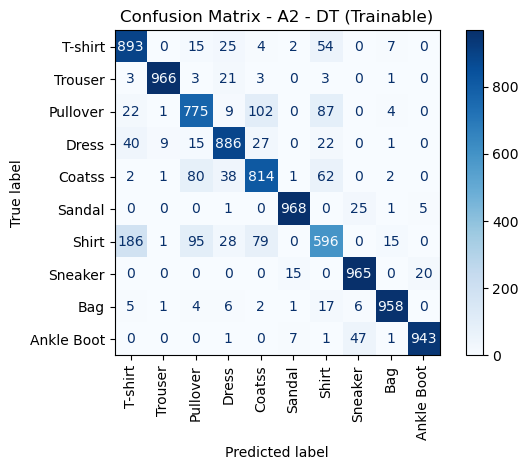


 Confusion Matrix per: A1 - DT (Trainable)


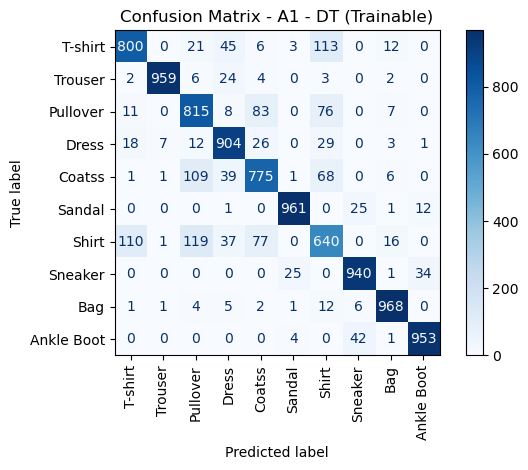


 Confusion Matrix per: A1 - HF (Frozen)


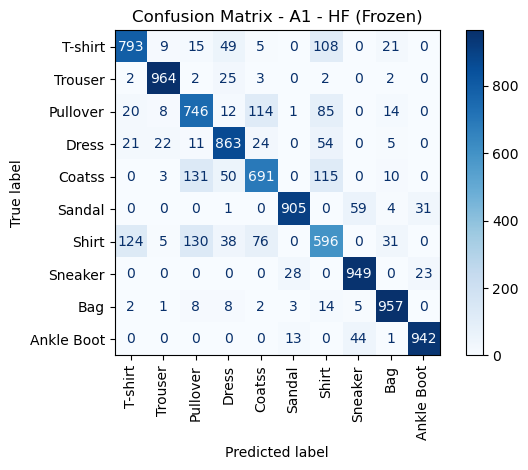


 Confusion Matrix per: A2 - HF (Frozen)


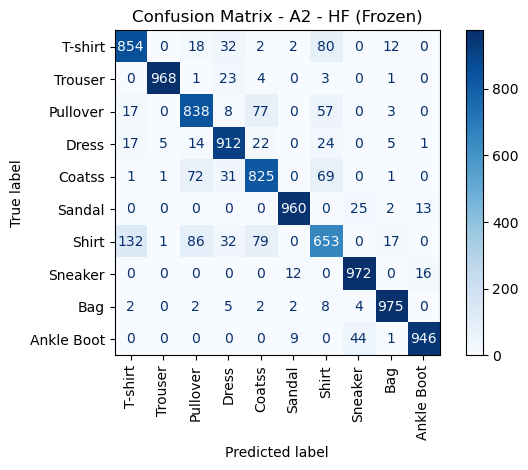


 Confusion Matrix per: A1 - HT (Trainable)


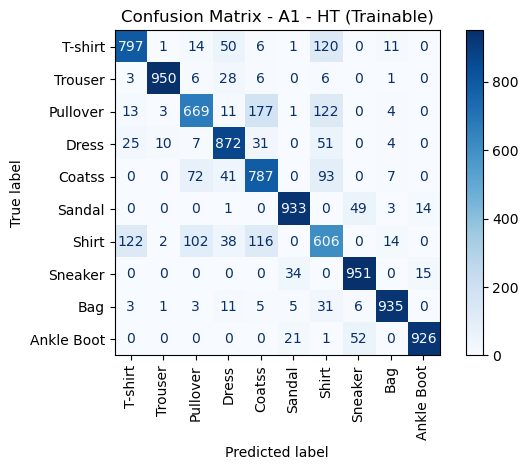


 Confusion Matrix per: A2 - HT (Trainable)


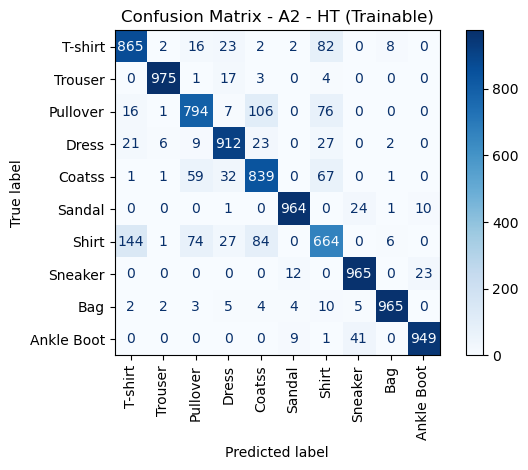

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def get_model_from_label(label):
    if "A1" in label:
        if "DT" in label:
            return NetA1Default()
        else:
            freeze = "HF" in label
            return NetA1ByHand(freeze_first_layer=freeze)
    elif "A2" in label:
        if "DT" in label:
            return NetA2Default()
        else:
            freeze = "HF" in label
            return NetA2ByHand(freeze_first_layer=freeze, )
    else:
        raise ValueError(f"Modello sconosciuto nel label: {label}")


def plot_confusion_matrix(model, dataloader, labels_map=None, model_name="Modello"):
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)

    display_labels = [labels_map[i] for i in range(len(cm))] if labels_map else None
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()


models_dir = "models"
for file_name in os.listdir(models_dir):
    if file_name.endswith(".pt"):
        model_label = file_name.replace(".pt", "")
        model_path = os.path.join(models_dir, file_name)

        print(f"\n Confusion Matrix per: {model_label}")
        model = get_model_from_label(model_label)

        checkpoint = torch.load(model_path)
        if isinstance(checkpoint, dict) and "model_weights" in checkpoint:
            model.load_state_dict(checkpoint["model_weights"])
        else:
            model.load_state_dict(checkpoint)

        plot_confusion_matrix(model, test_dataloader, labels_map=labels_map, model_name=model_label)

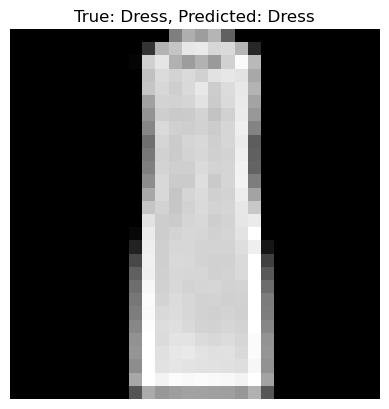

In [20]:
model_label = "A1 - HF (FROZEN)"
model_path = f"models/{model_label}.pt"

net = NetA1ByHand()
checkpoint = torch.load(model_path)
state_dict = checkpoint["model_weights"] if "model_weights" in checkpoint else checkpoint
net.load_state_dict(state_dict)
net.eval()

sample_index = random.randint(0, len(test_data) - 1)
sample_image, true_label = test_data[sample_index]

sample_image = sample_image.unsqueeze(0)

with torch.no_grad():
    output = net(sample_image)

predicted_label = torch.argmax(output, dim=1).item()

image = transforms.ToPILImage()(sample_image.squeeze(0).cpu())
plt.imshow(image, cmap='gray')
plt.title(f'True: {labels_map[true_label]}, Predicted: {labels_map[predicted_label]}')
plt.axis('off')
plt.show()